<a href="https://colab.research.google.com/github/katruramyasri123/Basics_of_POWERBI/blob/master/Supply_Chain_Management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df=pd.read_csv("delhivery_data.csv")


/tmp/ipython-input-3616227234.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("delhivery_data.csv")


In [ ]:
time_cols = [
    'trip_creation_time',
    'od_start_time',
    'cutoff_timestamp'
]

for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')


In [ ]:
df.head(1)

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:27:55,10.43566,14.0,11.0,11.9653,1.272727,14.0,11.0,11.9653,1.272727


In [ ]:
df['delay_minutes'] = df['actual_time'] - df['osrm_time']


In [ ]:
df['on_time_delivery'] = (df['delay_minutes'] <= 0).astype(int)


In [ ]:
df['trip_hour'] = df['od_start_time'].dt.hour


In [ ]:
df['distance_diff'] = df['actual_distance_to_destination'] - df['osrm_distance']


In [ ]:
df = df.dropna()


In [ ]:
df[['delay_minutes',
    'osrm_time',
    'actual_time',
    'osrm_distance',
    'actual_distance_to_destination']].describe()


,delay_minutes,osrm_time,actual_time,osrm_distance,actual_distance_to_destination
count,37142.000000,37142.000000,37142.000000,37142.000000,37142.000000
mean,201.592941,212.875613,414.468553,283.303017,232.671385
std,301.489675,305.470514,593.996449,417.387188,341.661190
min,-110.000000,6.000000,9.000000,9.098800,9.000267
25%,21.000000,27.000000,50.000000,29.783825,23.275269
50%,65.000000,65.000000,132.000000,79.291350,66.227746
75%,250.000000,260.000000,516.000000,348.605800,287.101253
max,2647.000000,1611.000000,4154.000000,2191.166400,1722.009755


In [ ]:
corr = df[
    ['delay_minutes',
     'osrm_time',
     'osrm_distance',
     'actual_distance_to_destination',
     'segment_osrm_time']
].corr()

corr


,delay_minutes,osrm_time,osrm_distance,actual_distance_to_destination,segment_osrm_time
delay_minutes,1.000000,0.915475,0.919227,0.921247,0.160146
osrm_time,0.915475,1.000000,0.999065,0.995877,0.186430
osrm_distance,0.919227,0.999065,1.000000,0.997161,0.177770
actual_distance_to_destination,0.921247,0.995877,0.997161,1.000000,0.166070
segment_osrm_time,0.160146,0.186430,0.177770,0.166070,1.000000


In [ ]:
df['delay_minutes'].value_counts()


,count
delay_minutes,
10.0,499
11.0,494
12.0,493
16.0,488
8.0,470
...,...
1077.0,1
1321.0,1
1242.0,1


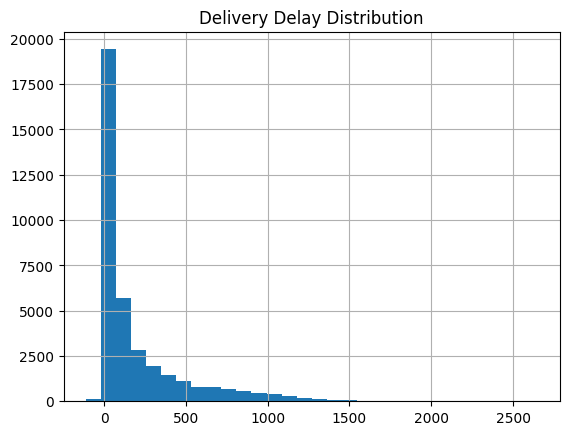

In [ ]:
import matplotlib.pyplot as plt

df['delay_minutes'].hist(bins=30)
plt.title("Delivery Delay Distribution")
plt.show()


In [ ]:
source_perf = df.groupby('source_name')['delay_minutes'].mean().sort_values(ascending=False)
source_perf


,delay_minutes
source_name,
Helencha_ColnyDPP_D (West Bengal),1059.800000
Mahasamund_RajpurRD_D (Chhattisgarh),818.000000
Guwahati_Hub (Assam),808.877551
Ranaghat_ArickDPP_D (West Bengal),808.250000
Phulpur_Shekhpur_D (Uttar Pradesh),796.507692
...,...
Mahbubabad_Yellanda_D (Telangana),-12.423077
Gajraula_JawaharN_D (Uttar Pradesh),-15.625000
Namsai_HelipadRD_D (Arunachal Pradesh),-25.422222


In [ ]:
dest_perf = df.groupby('destination_name')['delay_minutes'].mean().sort_values(ascending=False)
dest_perf.head(5)


,delay_minutes
destination_name,
Guwahati_Hub (Assam),599.609865
Kolkata_Dankuni_HB (West Bengal),583.339909
Delhi_Airport_H (Delhi),541.053097
Ranchi_Hub (Jharkhand),538.302083
Dhule_MIDCAvdn_I (Maharashtra),499.111111


In [ ]:
df[['actual_distance_to_destination', 'delay_minutes']].corr()


,actual_distance_to_destination,delay_minutes
actual_distance_to_destination,1.000000,0.921247
delay_minutes,0.921247,1.000000


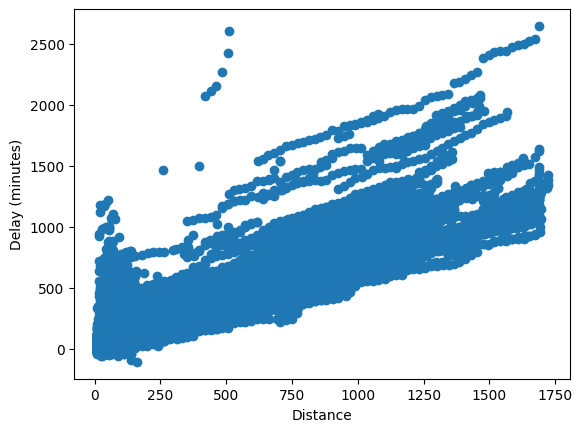

In [ ]:
plt.scatter(df['actual_distance_to_destination'], df['delay_minutes'])
plt.xlabel("Distance")
plt.ylabel("Delay (minutes)")
plt.show()


In [ ]:
le = LabelEncoder()
df['route_type_encoded'] = le.fit_transform(df['route_type'])


In [ ]:
y = df['delay_minutes']


In [ ]:
X = df[
    ['osrm_time',
     'osrm_distance',
     'actual_distance_to_destination',
     'segment_osrm_time',
     'segment_osrm_distance',
     'trip_hour',
     'distance_diff']
]


In [ ]:
train_df = df[df['data'] == 'training']
test_df  = df[df['data'] == 'test']

X_train = train_df[X.columns]
y_train = train_df['delay_minutes']

X_test  = test_df[X.columns]
y_test  = test_df['delay_minutes']


In [ ]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
y_pred = rf_model.predict(X_test)


In [ ]:
df['data'].value_counts()


,count
data,
training,26569
test,10573


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)


MAE : 62.03764305305968
RMSE: 143.98955062526275
R²  : 0.8373117570470439


In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance


,Feature,Importance
1,osrm_distance,0.780659
2,actual_distance_to_destination,0.115990
6,distance_diff,0.039273
5,trip_hour,0.024536
4,segment_osrm_distance,0.016608
0,osrm_time,0.013557
3,segment_osrm_time,0.009376


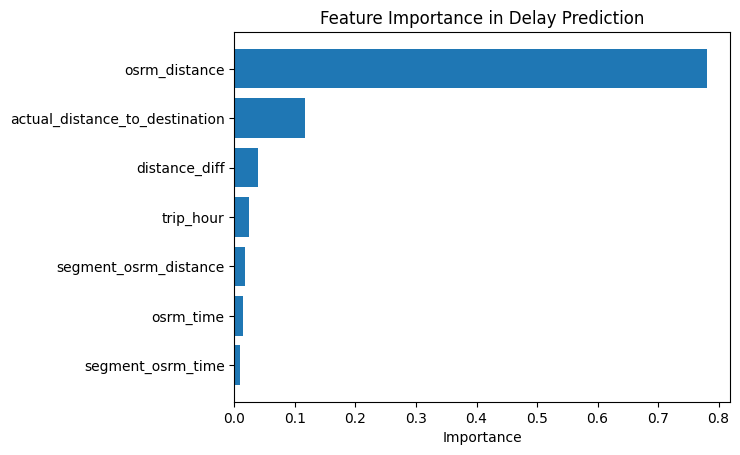

In [ ]:
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel("Importance")
plt.title("Feature Importance in Delay Prediction")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
df_final = df[[
    'trip_uuid',
    'source_name',
    'destination_name',
    'route_type',
    'trip_hour',
    'osrm_distance',
    'actual_distance_to_destination',
    'distance_diff',
    'delay_minutes',
    'on_time_delivery'
]]

df_final.to_csv("supply_chain_dashboard.csv", index=False)


In [ ]:
len(df_final)

37142

In [ ]:
print(df_final['trip_uuid'].duplicated().sum())
print(df['trip_uuid'].duplicated().sum())


33241
33241
